In [1]:
from qiskit import *
from qiskit.result.result import Result, ExperimentResult
from qiskit.providers.aer.noise import *
from qiskit.providers.aer.noise.device import basic_device_noise_model

from qiskit.test.mock import FakeAthens

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

import numpy as np

import sys
sys.path.append('../')

from qiskit_utilities.utilities import *

from zero_noise_extrapolation_cnot import ZeroNoiseExtrapolation
from zero_noise_extrapolation import mitigate, Richardson_extrapolate

import pickle
from typing import List

import matplotlib.pyplot as plt
%matplotlib inline

sim_backend = Aer.get_backend("qasm_simulator")
mock_backend = FakeAthens()

In [2]:
def add_swaptest_gate(qc, probe, q1, q2, barrier=False):
    qc.toffoli(probe, q1, q2)
    
    if barrier:
        qc.barrier()
        
    qc.toffoli(probe, q2, q1)
    
    if barrier:
        qc.barrier()
    
    qc.toffoli(probe, q1, q2)
    
def create_3qswaptest_circuit(barrier=False):
    qc = QuantumCircuit(3,1)
    
    qc.h(0)
    
    qc.h(1)
    
    if barrier:
        qc.barrier()
    
    add_swaptest_gate(qc, 0, 1, 2, barrier=barrier)
    
    if barrier:
        qc.barrier()
    
    qc.h(0)
    
    qc.measure(0,0)
    
    return qc

The SWAP-test circuit on two 1-qubit states is constructed as shown belown, using 3 Toffoli-gates (https://arxiv.org/abs/1712.09271).

We prepare the states q_1 = (|0> + |1>)/sqrt(2) and q_2 = |0>, while q_0 is called the probe qubit. The Z-measurement on the probe qubits measures the overlap between the state on q_1 and q_2. The true expectation value in this case is 0.5.

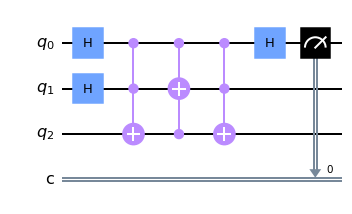

In [3]:
qc = create_3qswaptest_circuit()

qc.draw(output="mpl")

Each Toffoli-gate can be decomposed in the following way. Note that one Toffoli gate has a CNOT complexity of 6. A SWAP-test circuit on two n-qubit states, thus 2n + 1 qubits in total, requires 3n Toffoli gates.

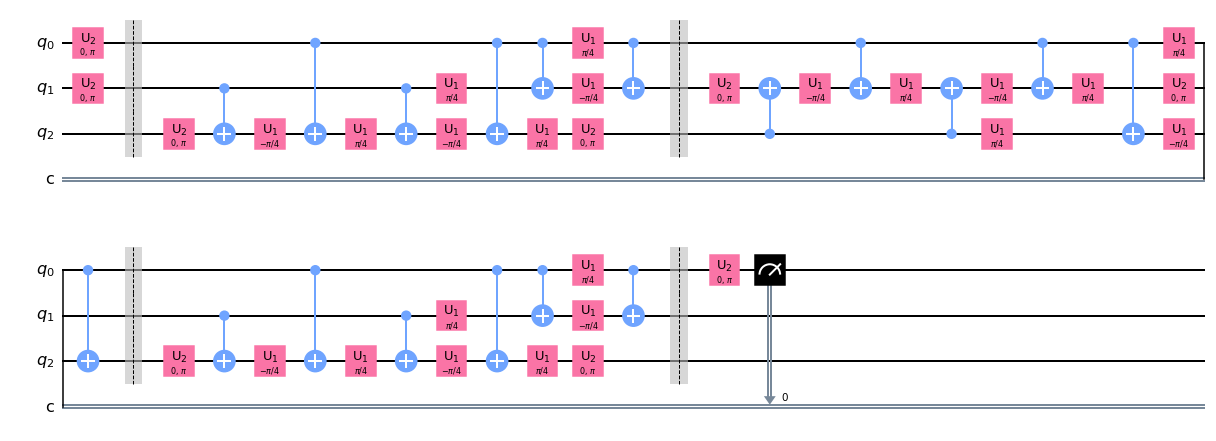

In [4]:
pass_manager = PassManager(Unroller(["u1","u2","u3","cx"]))

qc_swap = create_3qswaptest_circuit(barrier=True)

qc_unrolled = pass_manager.run(qc_swap)

qc_unrolled.draw(output="mpl")

We specify the expectation value function that computes the estimated expectation value from a set of quantum circuit experiment results.

The repeating CNOTs implementation requires the expectation value function to return both the expectation value and the variances. The random Pauli-sampling implementation requires only the expectation value. To reuse code, we specify a filter to be passed to the function that specifies the method used.

In [5]:
def swaptest_exp_val_func(results: List[ExperimentResult], myfilter=None):
    exp_vals = np.zeros(len(results))
    variances = np.zeros(len(results))
    for i,experiment_result in enumerate(results):
        shots = experiment_result.shots
        counts = experiment_result.data.counts
        eigenval = 0
        for key in counts.keys():
            if key == "0x0":
                eigenval = +1
            elif key == "0x1":
                eigenval = -1
            exp_vals[i] += eigenval*counts[key] / shots
        variances[i] = 1 - exp_vals[i]**2
    if myfilter is not None and myfilter["repeatingcnots"]:
        return exp_vals, variances
    else:
        return exp_vals

Zero noise extrapolation, mitigating noise on CNOT-gates, on the SWAP-test circuit. Executing the circuits on a simulator with a stochastic Pauli noise model. We choose the noise probability on CNOT-gates to be an order of magnitude larger than on the u1/u2/u3 single-qubit gates, which is realistic for modern quantum processors.

Noise amplification factors = [1,3,5,7,9]

In [6]:
def create_depolarizing_error_model(p_cnot, p_u, p_meas):
    X = np.asarray([[0, 1], [1, 0]])
    Y = np.asarray([[0, -1j], [1j, 0]])
    Z = np.asarray([[1, 0], [0, -1]])
    I = np.asarray([[1, 0], [0, 1]])

    pauli_dict = {"X": X, "Y": Y, "Z": Z, "I": I}

    # Two-qubit depolarizing error channel with error rate p_cnot on CNOT-gates
    kraus_operators_cnot = [np.sqrt(1-p_cnot)*np.kron(I,I)]

    for a in ["I","X","Y","Z"]:
        for b in ["I","X","Y","Z"]:
            if not ((a=="I") and (b=="I")):
                op = np.kron(pauli_dict[a], pauli_dict[b])
                kraus_operators_cnot.append(np.sqrt(p_cnot/15)*op)

    cnot_error = QuantumError(noise_ops=kraus_operators_cnot, number_of_qubits=2)

    # One-qubit depolarizing error channel with error rate p_u on all single-qubit gates
    kraus_operators_u = [np.sqrt(1-p_u)*I, np.sqrt(p_u/3) * X, np.sqrt(p_u/3) * Y, np.sqrt(p_u/3)*Z]
    u_error = QuantumError(noise_ops=kraus_operators_u, number_of_qubits=1)

    # One-qubit depolarizing error channel with error rate p_meas on all measurement gates
    kraus_operators_meas = [np.sqrt(1-p_meas)*I, np.sqrt(p_meas/3) * X, np.sqrt(p_meas/3) * Y, np.sqrt(p_meas/3)*Z]
    meas_error = QuantumError(noise_ops=kraus_operators_meas, number_of_qubits=1)
    
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(cnot_error, ["cx"])
    noise_model.add_all_qubit_quantum_error(u_error, ["u2","u3"])
    noise_model.add_all_qubit_quantum_error(meas_error, ["measure"])
    
    return noise_model

p_cnot = 0.01
p_u = 0.001
p_meas = 0.05
    
noise_model = create_depolarizing_error_model(p_cnot, p_u, p_meas)

N_AMP_FACTORS = 7 # -> amplification_factors = [1,3,5,7,9,11,13]
SHOTS = 1024*8192

qem = ZeroNoiseExtrapolation(qc=qc, exp_val_func=swaptest_exp_val_func, backend=sim_backend,
                             exp_val_filter={"repeatingcnots": True}, noise_model=noise_model,
                             n_amp_factors=N_AMP_FACTORS, shots=SHOTS,
                             save_results=True, experiment_name="3qswaptest_paulinoisemodel")

qem.mitigate(verbose=True)


Amplification factor = 1.
Noise amplified result successfully read from disk.
Noise amplified exp val = 0.39123917, variance = 0.84683265, total shots executed = 8388608.
Amplification factor = 3.
Noise amplified result successfully read from disk.
Noise amplified exp val = 0.27788734, variance = 0.92266582, total shots executed = 8388608.
Amplification factor = 5.
Noise amplified result successfully read from disk.
Noise amplified exp val = 0.19675660, variance = 0.96117035, total shots executed = 8388608.
Amplification factor = 7.
Noise amplified result successfully read from disk.
Noise amplified exp val = 0.13966966, variance = 0.98036979, total shots executed = 8388608.
Amplification factor = 9.
Noise amplified result successfully read from disk.
Noise amplified exp val = 0.09886336, variance = 0.99010501, total shots executed = 8388608.
Amplification factor = 11.
Noise amplified result successfully read from disk.
Noise amplified exp val = 0.07036972, variance = 0.99492316, total

0.4602825874462453

To examine if this method of noise amplification works as expected, we construct a set of noise models where the noise on CNOT-gates is manually ajusted to be amplified by the same set of noise amplification factors. This is done by setting the error rate on the CNOT-gate to p_r = r * p_0, where r is the amplification factor and p_0 the bare error rate. Noise on single-qubit gates and on measurements is kept the same.

Note that this does not represent an actual feasible method of noise amplification as we "amplify" the noise in the very definition of the specific different noise models. But this shall serve as a sanity check for the noise amplification scheme by CNOT repetition. If the scheme amplifies noise as expected we should find the noise amplified expectation value for each amplification factor to align closely with the expectation value found with the corresponding amplified noise model.

In [7]:
filename = "results" + "/" + "3qswaptest_paulinoisemodel" + \
           "_noisemodelamplification_ampfactors{:}_shots{:}".format(N_AMP_FACTORS, qem.shots)

data_loaded = False

if os.path.isfile(filename):
    file = open(filename, "rb")
    noisemodels_amplified_exp_vals = pickle.load(file)
    file.close()
    
    if noisemodels_amplified_exp_vals is not None:
        print("Amplified exp vals read from file.")
        data_loaded = True

if not data_loaded:
    amplified_noise_models = []

    for amplification_factor in qem.noise_amplification_factors:
        p_cnot_amplified = amplification_factor * p_cnot

        amplified_noise_models.append(create_depolarizing_error_model(p_cnot_amplified, p_u, p_meas))

    noisemodels_amplified_exp_vals = np.zeros(np.shape(amplified_noise_models)[0])

    shots, repeats = qem.partition_shots(qem.shots)

    for i, nm in enumerate(amplified_noise_models):
        job = execute([qem.qc for i in range(repeats)], sim_backend, shots=shots, noise_model=nm)
        exp_vals_temp,_ = swaptest_exp_val_func(job.result().results)
        noisemodels_amplified_exp_vals[i] = np.average(exp_vals_temp)
    
    file = open(filename, "wb")
    pickle.dump(noisemodels_amplified_exp_vals, file)
    file.close()
    print("Amplified exp vals written to file.")

print(noisemodels_amplified_exp_vals)

Amplified exp vals read from file.
[0.39198685 0.2758348  0.19391012 0.13463688 0.09251571 0.06230164
 0.04276776]


Plotting the noise amplified expectation values against each other, we find exactly what we expected. The noise amplification scheme by CNOT repetition seems to amplify the noise present in CNOT-gates very closely to the desired amplification factor.

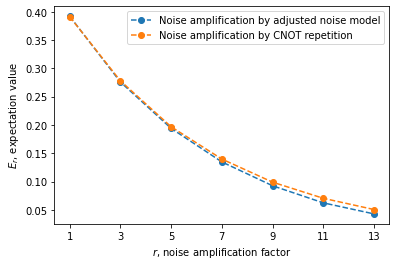

In [8]:
x = qem.noise_amplification_factors
y = qem.noise_amplified_exp_vals

plt.xlabel(r"$r$, noise amplification factor")
plt.ylabel(r"$E_r$, expectation value")

plt.xticks(x)

plt.plot(x, noisemodels_amplified_exp_vals,'--o', label="Noise amplification by adjusted noise model")
plt.plot(x, y,'--o', label="Noise amplification by CNOT repetition")

plt.legend()

plt.show()

We plot the mitigated expectation value, as a function of the number of noise amplification factors used, and we can see a noticable improvement.

From the plot above we observe that the noise amplified expectation values are being slightly over-estimated for the last amplification factors for the repeating CNOTs-method. Correspondingly, we observe that the mitigated expectation value flattens off and fails to improve when including these amplification factors.

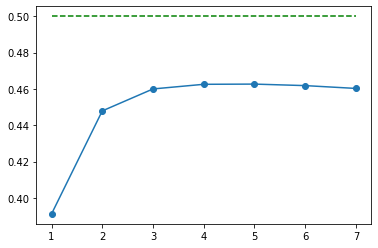

In [9]:
n_amp_factors = qem.n_amp_factors
noise_amplified_exp_vals = qem.noise_amplified_exp_vals
noise_amplification_factors = qem.noise_amplification_factors

mitigated_exp_vals = np.zeros(n_amp_factors)
mitigated_exp_vals[0] = noise_amplified_exp_vals[0]

for n in range(1, n_amp_factors):
    mitigated_exp_vals[n] = Richardson_extrapolate(noise_amplified_exp_vals[0:n+1], noise_amplification_factors[0:n+1])[0]
    
x = [i+1 for i in range(n_amp_factors)]
ideal_exp_val = [0.5 for i in range(n_amp_factors)]

plt.plot(x, ideal_exp_val, '--g')
plt.plot(x, mitigated_exp_vals, '-o')

plt.show()

Zero noise extrapolation, mitigating noise on CNOT-gates, on the SWAP-test circuit. Now on the mock backend FakeAthens that emulates the IBMQ Athens quantum device. This mock backend has the same configurations as the real device, and an noise model that aims to approximate the physical device as closely as possible.

Noise amplification factors = [1,3,5,7,9]

In [10]:
#load IBMQ account
#IBMQ.save_account('Your IBMQ token')
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q")

athens_backend = provider.get_backend("ibmq_athens")

athens_noise_model = NoiseModel.from_backend(athens_backend)

C:\Users\ander\.conda\envs\qcomp\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [11]:
N_AMP_FACTORS = 7 # -> amplification_factors = [1,3,5,7,9,11,13]
SHOTS = 2048*8192

qc_transpiled = transpile(qc, athens_backend, optimization_level=3)

qem = ZeroNoiseExtrapolation(qc=qc_transpiled, exp_val_func=swaptest_exp_val_func, backend=sim_backend, 
                             noise_model = athens_noise_model,
                             n_amp_factors=N_AMP_FACTORS, shots=SHOTS,
                             save_results=True, experiment_name="3qswaptest_ibmqathensnoisemodel")

qem.mitigate(verbose=True)

Amplification factor = 1.
Noise amplified result successfully read from disk.
Noise amplified exp val = 0.29174495, variance = 0.91477763, total shots executed = 16777216.
Amplification factor = 3.
Noise amplified result successfully read from disk.
Noise amplified exp val = 0.10535479, variance = 0.98877137, total shots executed = 16777216.
Amplification factor = 5.
Noise amplified result successfully read from disk.
Noise amplified exp val = 0.04850841, variance = 0.99752100, total shots executed = 16777216.
Amplification factor = 7.
Noise amplified result successfully read from disk.
Noise amplified exp val = 0.03171182, variance = 0.99887338, total shots executed = 16777216.
Amplification factor = 9.
Noise amplified result successfully read from disk.
Noise amplified exp val = 0.02537715, variance = 0.99923966, total shots executed = 16777216.
Amplification factor = 11.
Noise amplified result successfully read from disk.
Noise amplified exp val = 0.02293003, variance = 0.99935403, 

0.4910504779547751

For comparisons we run also the zero-noise extrapolation implementation with noise amplification by random Pauli gate-sampling.

While the repeating CNOT-method requires odd noise amplificaiton factors (1, 3, 5, ..., 2n-1), the random Pauli-method seems to work best with powers of two (1, 2, 4, ..., 2^(n-1)).

In [12]:
two_qubit_error_map = get_cx_error_map(athens_backend)
athens_basis_gates = athens_noise_model.basis_gates

# we take the same transpiled circuit as used before, because there is some randomness involved in the transpilation
qc_transpiled = qem.qc

n_amp_factors = qem.n_amp_factors

# amplification factors as multiples of 2 seems to give better results for this method
amplification_factors_powersoftwo = [2**i for i in range(n_amp_factors)]

R,E_dict,E_av_dict,\
max_depth_dict,mean_depth_dict,\
max_depth_transpiled_dict,mean_depth_transpiled_dict,\
bn= mitigate(qc_transpiled, amplification_factors_powersoftwo,\
             swaptest_exp_val_func,\
             sim_backend, \
             "3qswaptest_ibmqathens", two_qubit_error_map,\
             8192, 2048,\
             athens_backend,\
             athens_noise_model,\
             athens_basis_gates,\
             paulitwirling=False
             )

print(R[-1])

Sanity checks passed
Result for job ' 3qswaptest_ibmqathens_backendqasm_simulator_noisemodelibmq_athens_shots8192_experiments2048_paulitwirlingFalse_r1 ' successfully read from disk
Result for job ' 3qswaptest_ibmqathens_backendqasm_simulator_noisemodelibmq_athens_shots8192_experiments2048_paulitwirlingFalse_r2 ' successfully read from disk
Result for job ' 3qswaptest_ibmqathens_backendqasm_simulator_noisemodelibmq_athens_shots8192_experiments2048_paulitwirlingFalse_r4 ' successfully read from disk
Result for job ' 3qswaptest_ibmqathens_backendqasm_simulator_noisemodelibmq_athens_shots8192_experiments2048_paulitwirlingFalse_r8 ' successfully read from disk
Result for job ' 3qswaptest_ibmqathens_backendqasm_simulator_noisemodelibmq_athens_shots8192_experiments2048_paulitwirlingFalse_r16 ' successfully read from disk
Result for job ' 3qswaptest_ibmqathens_backendqasm_simulator_noisemodelibmq_athens_shots8192_experiments2048_paulitwirlingFalse_r32 ' successfully read from disk
Result for 

We plot the mitigated expectation values as a function of the number of amplification factors used for both methods. We observe from the below plot that the repeating CNOTs-method converges a lot closer to the ideal expectation value than the random Pauli-method.

The random Pauli-method relies on approximating the quantum noise as a two-qubit depolarizing noise model. Optionally, doing a pauli-twirling before applying this assumption. The repeating CNOTs-method have no such assumptions about the character of the quantum noise. Thus, we might expected the latter to work better for general noise models, and exp

CNOT repetition, mitigated exp vals: [0.29174495 0.38494003 0.43351895 0.46148582 0.4778664  0.48694545
 0.49105048]
Random pauli gates, mitigated exp vals: [0.29193199 0.40144479 0.44075068 0.45646464 0.4634236  0.46669605
 0.46603722]


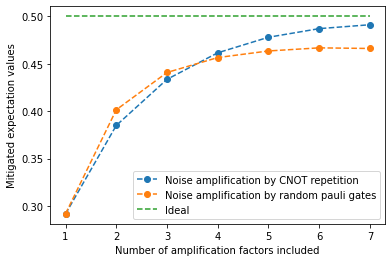

In [13]:
# Process results from ZNE with noise amplification by CNOT repetition:
n_amp_factors = qem.n_amp_factors
noise_amplified_exp_vals = qem.noise_amplified_exp_vals
noise_amplification_factors = qem.noise_amplification_factors

mitigated_exp_vals = np.zeros(n_amp_factors)
mitigated_exp_vals[0] = noise_amplified_exp_vals[0]

for n in range(1, n_amp_factors):
    mitigated_exp_vals[n] = Richardson_extrapolate(noise_amplified_exp_vals[0:n+1], noise_amplification_factors[0:n+1])[0]
    
print("CNOT repetition, mitigated exp vals:", mitigated_exp_vals)

# Process results from ZNE with noise amplification by random pauli gates:
noise_amplified_exp_vals_randompauliamplification = np.zeros(N_AMP_FACTORS)
mitigated_exp_vals_randompauliamplification = np.zeros(N_AMP_FACTORS)
for i,r in enumerate(amplification_factors_powersoftwo):
    noise_amplified_exp_vals_randompauliamplification[i] = E_av_dict[bn + "_r{:}".format(r)][-1]

mitigated_exp_vals_randompauliamplification[0] = noise_amplified_exp_vals_randompauliamplification[0]

for i in range(1, N_AMP_FACTORS):
    mitigated_exp_vals_randompauliamplification[i] = Richardson_extrapolate(noise_amplified_exp_vals_randompauliamplification[0:i+1],
                                                                            np.asarray(amplification_factors_powersoftwo[0:i+1]))[0]


print("Random pauli gates, mitigated exp vals:", mitigated_exp_vals_randompauliamplification)
    
# Plotting
x = [i+1 for i in range(N_AMP_FACTORS)]

plt.xlabel("Number of amplification factors included")
plt.ylabel("Mitigated expectation values")

plt.plot(x, mitigated_exp_vals, "--o", label="Noise amplification by CNOT repetition")
plt.plot(x, mitigated_exp_vals_randompauliamplification, "--o", label="Noise amplification by random pauli gates")
plt.plot(x, [0.5 for i in range(len(x))], "--", label="Ideal")

plt.legend()

plt.show()

Qiskit version:

In [14]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.0',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.23.0'}